<a href="https://colab.research.google.com/github/brainmentorspvtltd/IGDTU_ImageProcessingTF/blob/main/IG_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dense, Dropout, Lambda

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [7]:
y_train[0]

5

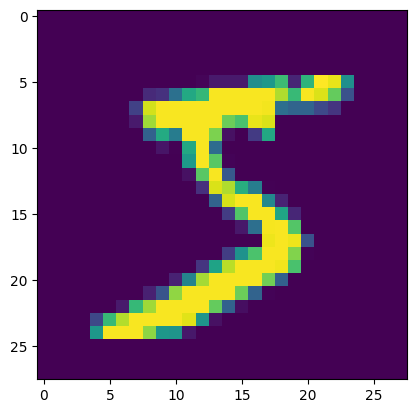

In [8]:
plt.imshow(x_train[0])
plt.show()

In [13]:
def showImages(X, y=None, index=100, numImg = 4):
  for i in range(numImg):
    fig = plt.subplot(4, 4, i+1)
    fig.axis("off")
    plt.imshow(X[index+i], cmap="Greys")
    plt.title(y[index+i])
  plt.show()

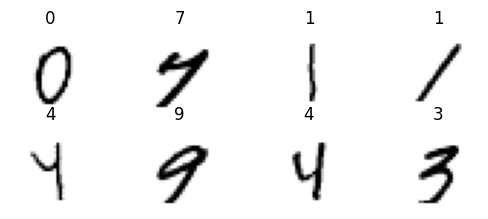

In [14]:
showImages(x_train, y_train, index=1000, numImg=8)

In [15]:
index = [np.where(y_train == i)[0] for i in range(10)]

In [16]:
index

[array([    1,    21,    34, ..., 59952, 59972, 59987]),
 array([    3,     6,     8, ..., 59979, 59984, 59994]),
 array([    5,    16,    25, ..., 59983, 59985, 59991]),
 array([    7,    10,    12, ..., 59978, 59980, 59996]),
 array([    2,     9,    20, ..., 59943, 59951, 59975]),
 array([    0,    11,    35, ..., 59968, 59993, 59997]),
 array([   13,    18,    32, ..., 59982, 59986, 59998]),
 array([   15,    29,    38, ..., 59963, 59977, 59988]),
 array([   17,    31,    41, ..., 59989, 59995, 59999]),
 array([    4,    19,    22, ..., 59973, 59990, 59992])]

In [23]:
def showPair(X, y, image):
  subplot = plt.subplot(1,2,1)
  plt.imshow(X[image][0])
  subplot.axis("off")
  subplot = plt.subplot(1,2,2)
  subplot.axis("off")
  plt.imshow(X[image][1])
  plt.title(y[image])
  plt.show()

In [28]:
# Create Pairs - we need to pass a pair of objects
# and a label indicating that objects are equal or not

# min_pairs - how many equal pairs as min we want in the dataset
def create_pairs(X, y, min_pairs=2000):
  pairs = []
  labels = []
  equal_items = 0
  # we have 10 classes
  # index[1] - all positions with values equals to 1
  # index[2] - all positions with values equals to 2
  index = [np.where(y == i)[0] for i in range(10)]

  for item in range(len(X)):
    if equal_items < min_pairs:
      random_index = np.random.randint(len(index[y[item]]))
      num_pairs = index[y[item]][random_index]
      equal_items += 1
    else:
      num_pairs = np.random.randint(len(X))

    labels += [y[item] == y[num_pairs]]
    pairs += [[X[item], X[num_pairs]]]

  return np.array(pairs), np.array(labels).astype("float32")

In [29]:
train_pairs, train_labels = create_pairs(x_train, y_train)
test_pairs, test_labels = create_pairs(x_test, y_test)

In [30]:
train_pairs.shape

(60000, 2, 28, 28)

In [33]:
train_labels.shape

(60000,)

In [34]:
train_labels[0]

1.0

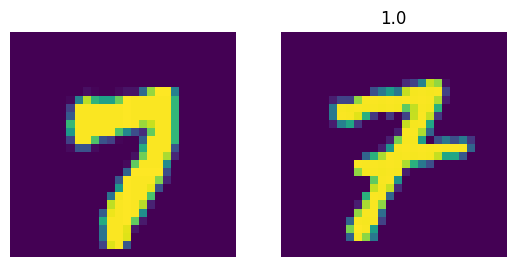

In [32]:
showPair(train_pairs, train_labels, 1343)